In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from nilearn.plotting import plot_design_matrix, plot_stat_map, view_img
from nilearn.reporting import get_clusters_table
from nilearn import datasets
import glob
import os
import numpy as np
import pandas as pd

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
def get_filt_tval_img(reg, reg_rt = "1", mnum = "1", mname = 'overall_mean', tstat="1", threshold=0.95):
    
    level3_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level3/'
    model_path = 'model'+mnum+'_reg-rt'+reg_rt
    img_path = os.path.join(level3_path, model_path, mname, reg+'_'+model_path)
    
    pos_pval_fn = 'rand_tfce_corrp_%s_%s_model%s_reg-rt%s_tstat%s.nii.gz'%(mname, reg, mnum, reg_rt, tstat)
    neg_pval_fn = 'rand_tfce_corrp_%s_%s_model%s_reg-rt%s_tstat%s.nii.gz'%(mname, 'neg_'+reg, mnum, reg_rt, tstat)
    tval_fn = 'rand_tfce_%s_%s_model%s_reg-rt%s_tstat%s.nii.gz'%(mname, reg, mnum, reg_rt, tstat)
    
    pos_pval_img = os.path.join(img_path, pos_pval_fn)
    neg_pval_img = os.path.join(img_path, neg_pval_fn)
    tval_img = os.path.join(img_path, tval_fn)
    
    pos_pval_img = nib.load(pos_pval_img)
    neg_pval_img = nib.load(neg_pval_img)
    tval_img = nib.load(tval_img)
    
    tval_data = tval_img.get_fdata()
    pos_pval_data = pos_pval_img.get_fdata()
    neg_pval_data = neg_pval_img.get_fdata()
    
    filt_tval_data = np.where(pos_pval_data > threshold, tval_data, np.where(neg_pval_data > threshold, tval_data, 0))
    filt_tval_img = nib.Nifti1Image(filt_tval_data.astype(np.float64), tval_img.affine)
    
    return filt_tval_img

def plot_filt_tval_img(reg, reg_rt = "1", mnum = "1", mname = 'overall_mean', tstat="1", threshold=0.95, interactive=False, cut_coords = None, display_mode = 'ortho', draw_cross=False):
    filt_tval_img = get_filt_tval_img(reg=reg, reg_rt = reg_rt, mnum = mnum, mname = mname, tstat=tstat, threshold=threshold)
    title='%s_model%s_reg-rt%s'%(reg, mnum, reg_rt)
    
    if(len(np.unique(filt_tval_img.get_fdata())) == 1):
        print('Nothing survives correction for %s, model = %s, tstat = %s, reg_rt = %s at threshold p < %s'%(reg, mnum, tstat, reg_rt, str(round(1-threshold, 2))))
    elif interactive:
        view = view_img(filt_tval_img, 
             draw_cross=draw_cross,
             title=title, cut_coords = cut_coords)
        
        return view
    else:
        print('Plotting tvalues filtered for corrected p values < %s'%str(round(1-threshold, 2)))
        plot_stat_map(filt_tval_img, 
             draw_cross=draw_cross,
             title=title, cut_coords = cut_coords, display_mode = display_mode)

        
def get_filt_diff_tval_img(reg, reg_rt1, reg_rt2, mnum1, mnum2, mname, tstat="1", threshold=0.95):
    
    img1 = get_filt_tval_img(reg=reg, reg_rt = reg_rt1, mnum = mnum1, mname = mname, tstat=tstat, threshold=threshold)
    img2 = get_filt_tval_img(reg=reg, reg_rt = reg_rt2, mnum = mnum2, mname = mname, tstat=tstat, threshold=threshold)
    
    img1_data = img1.get_fdata()
    img2_data = img2.get_fdata()
    filt_diff_tval_data = img1_data - img2_data
    filt_diff_tval_img = nib.Nifti1Image(filt_diff_tval_data.astype(np.float64), img1.affine)
    
    return filt_diff_tval_img
        
def plot_filt_diff_tval_img(reg, reg_rt1, reg_rt2, mnum1, mnum2, mname = 'overall_mean', tstat="1", threshold=0.95, disp_threshold = 2, interactive=False, cut_coords = None, display_mode = 'ortho', draw_cross=False):
    filt_diff_tval_img = get_filt_diff_tval_img(reg=reg, reg_rt1 = reg_rt1, reg_rt2 = reg_rt2, mnum1 = mnum1, mnum2 = mnum2, mname = mname, tstat=tstat, threshold=threshold)
    title='%s model%s_reg-rt%s - model%s_reg-rt%s '%(reg, mnum1, reg_rt1, mnum2, reg_rt2)
    
    if(len(np.unique(filt_diff_tval_img.get_fdata())) == 1):
        print('Nothing survives correction for the difference image %s, model = %s, tstat = %s, reg_rt = %s at threshold p < %s'%(reg, mnum, tstat, reg_rt, str(round(1-threshold, 2))))
    
    elif interactive:
        view = view_img(filt_diff_tval_img, 
             draw_cross=draw_cross,
             title=title, cut_coords = cut_coords, threshold = disp_threshold)
        
        return view
    else:
        print('Plotting tvalues filtered for corrected p values < %s'%str(round(1-threshold, 2)))
        plot_stat_map(filt_diff_tval_img, 
             draw_cross=draw_cross,
             title=title, cut_coords = cut_coords, display_mode = display_mode, threshold = disp_threshold)

        
def get_mean_cor_df(reg_rt = "1", mnum = "1"):
    
    level3_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level3/'
    model_path = 'model'+mnum+'_reg-rt'+reg_rt
    df_path = os.path.join(level3_path, model_path, model_path+'_mean_desmat_cor.csv')
    
    mean_cor_df = pd.read_csv(df_path)
    
    return(mean_cor_df)

# Regressor types

- ev = event; amplitude = 1  
- par = parametric; amplitude = demeaned    
- st = stick (0 duration); amplitude = 1 
- rt = reaction time; amplitude = demeaned RT

# Model 1: fractalProb_ev + stim_ev + choiceShift_st + reward_ev

Correlation between regressors averaged across subjects and runs

In [3]:
get_mean_cor_df(reg_rt = "0", mnum = "1")

,Unnamed: 0,choiceShift_st,fractalProb_ev,reward_ev,stim_ev
0,choiceShift_st,1.000000,0.469240,0.745734,0.810597
1,fractalProb_ev,0.469240,1.000000,-0.102470,0.593296
2,reward_ev,0.745734,-0.102470,1.000000,0.446294
3,stim_ev,0.810597,0.593296,0.446294,1.000000


In [4]:
get_mean_cor_df(reg_rt = "1", mnum = "1")

,Unnamed: 0,choiceShift_st,fractalProb_ev,reward_ev,stim_ev,stim_rt
0,choiceShift_st,1.000000,0.469240,0.745734,0.920237,-0.053450
1,fractalProb_ev,0.469240,1.000000,-0.102470,0.711008,-0.000236
2,reward_ev,0.745734,-0.102470,1.000000,0.519857,-0.101782
3,stim_ev,0.920237,0.711008,0.519857,1.000000,-0.000236
4,stim_rt,-0.053450,-0.000236,-0.101782,-0.000236,1.000000


Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05


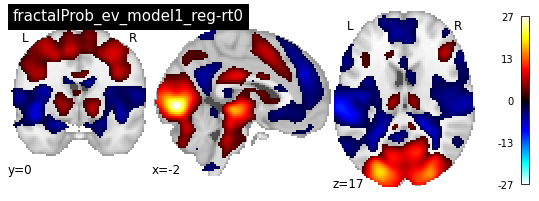

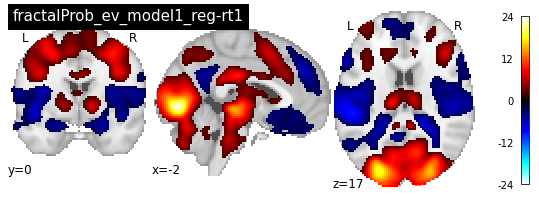

In [23]:
reg = 'fractalProb_ev'
mnum = '1'
mname = 'overall_mean'
tstat = '1'
cut_coords = (-2, 0, 17)

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = cut_coords)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = cut_coords)

# plot_filt_diff_tval_img(reg, reg_rt1="0", reg_rt2="1", mnum1=mnum, mnum2=mnum,  cut_coords = cut_coords)

Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05


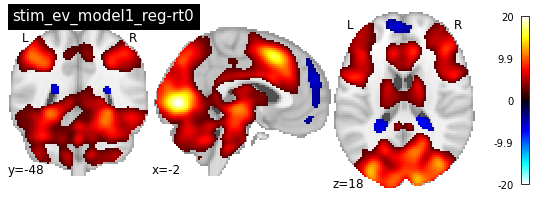

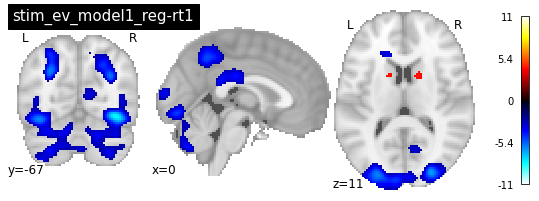

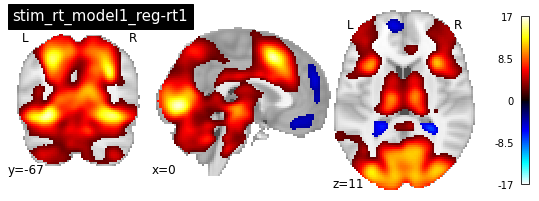

In [8]:
reg = 'stim_ev'
mnum = '1'
mname = 'overall_mean'
tstat = '1'
cut_coords = (0, -67, 11)

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = cut_coords)

reg = 'stim_rt'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = cut_coords)

Check for left motor cortex activity. Cross is the precentral gyrus peak reported in Hare et al.

Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05


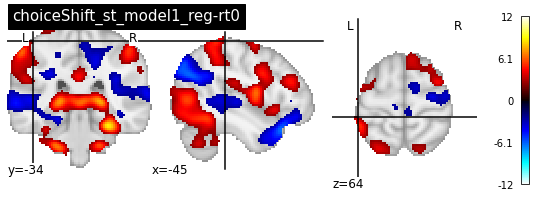

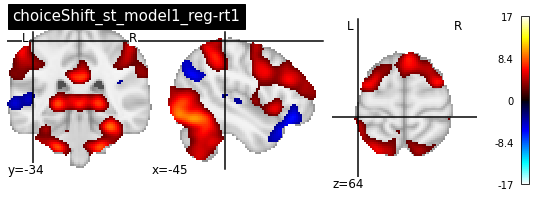

In [20]:
reg = 'choiceShift_st'
mnum = '1'
mname = 'overall_mean'
tstat = '1'
cut_coords = (-45, -34, 64)
draw_cross = True

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = cut_coords, draw_cross = draw_cross)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = cut_coords, draw_cross = draw_cross)

# plot_filt_diff_tval_img(reg, reg_rt1="0", reg_rt2="1", mnum1=mnum, mnum2=mnum, cut_coords = cut_coords, draw_cross = draw_cross)

Motor cortex activity is a little ventral than expected but more consistent for choiceShift regressor. It is, however, not lateralized to the left.

Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05


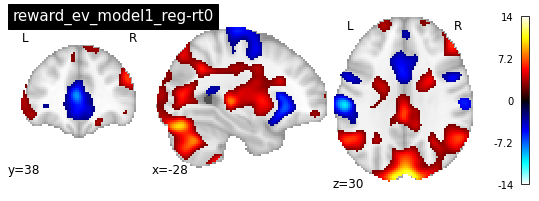

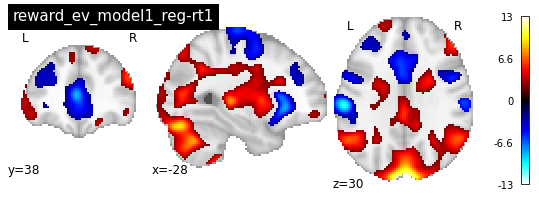

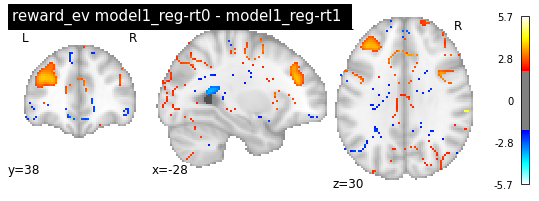

In [22]:
reg = 'reward_ev'
mnum = '1'
mname = 'overall_mean'
tstat = '1'
# cut_coords=(-6, 3, 29)
cut_coords=(-28, 38, 30)

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords=cut_coords)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords=cut_coords)

plot_filt_diff_tval_img(reg, reg_rt1="0", reg_rt2="1", mnum1=mnum, mnum2=mnum, cut_coords=cut_coords)

# Model 2: Model 1 + fractalProb_par

In [24]:
get_mean_cor_df(reg_rt = "0", mnum = "2")

,Unnamed: 0,choiceShift_st,fractalProb_ev,fractalProb_par,reward_ev,stim_ev
0,choiceShift_st,1.000000,0.469240,0.352629,0.745734,0.810597
1,fractalProb_ev,0.469240,1.000000,0.745471,-0.102470,0.593296
2,fractalProb_par,0.352629,0.745471,1.000000,-0.070972,0.426493
3,reward_ev,0.745734,-0.102470,-0.070972,1.000000,0.446294
4,stim_ev,0.810597,0.593296,0.426493,0.446294,1.000000


In [25]:
get_mean_cor_df(reg_rt = "1", mnum = "2")

,Unnamed: 0,choiceShift_st,fractalProb_ev,fractalProb_par,reward_ev,stim_ev,stim_rt
0,choiceShift_st,1.000000,0.469240,0.352629,0.745734,0.920237,-0.053450
1,fractalProb_ev,0.469240,1.000000,0.745471,-0.102470,0.711008,-0.000236
2,fractalProb_par,0.352629,0.745471,1.000000,-0.070972,0.530015,-0.033310
3,reward_ev,0.745734,-0.102470,-0.070972,1.000000,0.519857,-0.101782
4,stim_ev,0.920237,0.711008,0.530015,0.519857,1.000000,-0.000236
5,stim_rt,-0.053450,-0.000236,-0.033310,-0.101782,-0.000236,1.000000


In [34]:
reg = 'fractalProb_ev'
mnum = '2'
mname = 'overall_mean'
tstat = '1'
cut_coords = (1, 29, -14)

reg_rt = '0'
# plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)
# plot_filt_diff_tval_img(reg, reg_rt1="0", reg_rt2="0", mnum1="1", mnum2="2", cut_coords = cut_coords)

reg_rt = '1'
# plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = cut_coords)
# plot_filt_diff_tval_img(reg, reg_rt1="1", reg_rt2="1", mnum1="1", mnum2="2", cut_coords = cut_coords)

print('No interesting change from Model 1')

No interesting change from Model 1


Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05


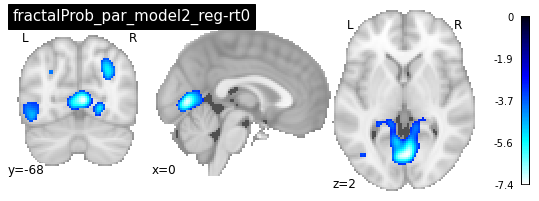

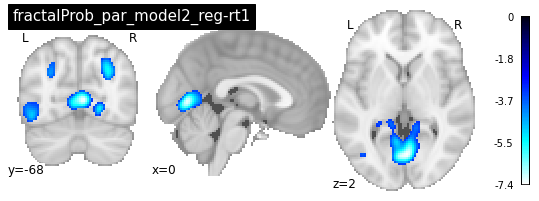

In [37]:
reg = 'fractalProb_par'
mnum = '2'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

# plot_filt_diff_tval_img(reg, reg_rt1="0", reg_rt2="1", mnum1=mnum, mnum2=mnum)
print('No interesting difference depending on rt modeling')

In [42]:
reg = 'stim_ev'
mnum = '2'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
# plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)
# plot_filt_diff_tval_img(reg, reg_rt1=reg_rt, reg_rt2=reg_rt, mnum1="1", mnum2=mnum)

reg_rt = '1'
# plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)
# plot_filt_diff_tval_img(reg, reg_rt1=reg_rt, reg_rt2=reg_rt, mnum1="1", mnum2=mnum)

reg = 'stim_rt'
# plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)
# plot_filt_diff_tval_img(reg, reg_rt1=reg_rt, reg_rt2=reg_rt, mnum1="1", mnum2=mnum)

print('No interesting change from Model 1')

No interesting change from Model 1


In [ ]:
reg = 'choiceShift_st'
mnum = '2'
mname = 'overall_mean'
tstat = '1'
cut_coords = (-45, -34, 64)
draw_cross = True

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = cut_coords, draw_cross = draw_cross)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = cut_coords, draw_cross = draw_cross)

In [ ]:
reg = 'reward_ev'
mnum = '2'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

# Model 3: Model 2 + valDiff_par

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "3")

In [ ]:
get_mean_cor_df(reg_rt = "1", mnum = "3")

In [ ]:
reg = 'fractalProb_ev'
mnum = '3'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

In [ ]:
reg = 'fractalProb_par'
mnum = '3'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

In [ ]:
reg = 'stim_ev'
mnum = '3'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg = 'stim_rt'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

In [ ]:
reg = 'choiceShift_st'
mnum = '3'
mname = 'overall_mean'
tstat = '1'
cut_coords = (-45, -34, 64)
draw_cross = True

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = cut_coords, draw_cross = draw_cross)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = cut_coords, draw_cross = draw_cross)

In [ ]:
reg = 'valDiff_par'
mnum = '3'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

In [ ]:
reg = 'reward_ev'
mnum = '3'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

# Model 4: Model 2 + valChosen + valUnchosen

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "4")

In [ ]:
get_mean_cor_df(reg_rt = "1", mnum = "4")

In [ ]:
reg = 'fractalProb_ev'
mnum = '4'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

In [ ]:
reg = 'fractalProb_par'
mnum = '4'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

In [ ]:
reg = 'stim_ev'
mnum = '4'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg = 'stim_rt'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

In [ ]:
reg = 'choiceShift_st'
mnum = '4'
mname = 'overall_mean'
tstat = '1'
cut_coords = (-45, -34, 64)
draw_cross = True

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = cut_coords, draw_cross = draw_cross)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = cut_coords, draw_cross = draw_cross)

In [ ]:
reg = 'valChosen_par'
mnum = '4'
mname = 'overall_mean'
tstat = '1'
threshold = 0.9

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, threshold=threshold)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, threshold=threshold)

In [ ]:
reg = 'valUnchosen_par'
mnum = '4'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

In [ ]:
reg = 'reward_ev'
mnum = '4'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

# Model 5: Model 2 + valDiffLottery + valDiffFractal

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "5")

In [ ]:
get_mean_cor_df(reg_rt = "1", mnum = "5")

In [ ]:
reg = 'fractalProb_ev'
mnum = '5'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

In [ ]:
reg = 'fractalProb_par'
mnum = '5'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

In [ ]:
reg = 'stim_ev'
mnum = '5'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg = 'stim_rt'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

In [ ]:
reg = 'choiceShift_st'
mnum = '5'
mname = 'overall_mean'
tstat = '1'
cut_coords = (-45, -34, 64)
draw_cross = True

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = cut_coords, draw_cross = draw_cross)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat, cut_coords = cut_coords, draw_cross = draw_cross)

In [ ]:
reg = 'valDiffLottery_par'
mnum = '5'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

In [ ]:
reg = 'valDiffFractal_par'
mnum = '5'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

In [ ]:
reg = 'reward_ev'
mnum = '5'
mname = 'overall_mean'
tstat = '1'

reg_rt = '0'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

reg_rt = '1'
plot_filt_tval_img(reg, reg_rt=reg_rt, mnum = mnum, mname = mname, tstat = tstat)

# Model 6: Model 2 + valChosenLottery + valUnchosenLottery + valChosenFractal + valUnchosenFractal

# Model ...: Model(3/4/5/6) + reward_par

# Model ...: Model(3/4/5/6) + rpe_par

# Model ...: Model(3/4/5/6) + reward_par + rpe_par